# Regression models for describing measurements

## What is regression?

Regression is a nice way of modelling measurements.

Maybe you have seen this regression model before:

$$
y = \alpha + X\cdot\beta + \epsilon
$$

Components:

-   $y$: a measurement
-   $\alpha$ and $\beta$ some unknown parameters, the same for every
    measurement
-   $X$ some real-valued features
-   $\epsilon$ an unknown number quantifying the difference between the
    prediction and the observation, different for each measurement

Often $\epsilon$ is assumed to have a normal distribution with location
zero and scale parameter $\sigma$.

Another way of saying the same thing:

$$
y \sim N(\alpha + X\cdot\beta, \sigma)
$$

I prefer this notation because it nicely separates the different
components, and doesn’t hide the error parameter $\sigma$. It also makes
it clear what you might change. For example $\alpha + X\cdot\beta$ is
just one option: there are many ways in which measurements and
predictors can be related. The normal distribution is also not required,
in fact it is often inappropriate.

The key features of a regression model:

-   a predictor that is some function of the parameters and features
-   a probabilistic relationship between the predictor and the
    measurement

> **Important**
>
> In the context of regression modelling, Bayesian inference lets you
> give free rein to your creativity when designing regressions, so you
> can make models that represent what you know about the measurement
> process.

### Generalised linear models

This is a popular and powerful class of regression model with the
following distinguishing characteristics:

-   The predictor is a **linear** function of the parameters and
    features, e.g.  $\alpha + X\cdot\beta$

-   The probability distribution describing measurement errors is
    **not** necessarily the normal distribution, e.g. log-normal,
    Poisson, Dirichlet, Gamma, …

-   There is a **link function** that connects the linear predictor with
    the probability distribution, e.g. $\ln(\alpha + X\cdot\beta)$.

An example GLM for positive-constrained measurements:

$$
y \sim LN(\ln(\alpha+X\cdot\beta), \sigma)
$$

### Tips for designing regression models

-   Start with the simplest GLM that obeys all known data constraints.
-   Try log-transforming things.
-   Aim to explicitly represent how you think the measurement apparatus
    works.
-   Heavy tailed distributions are often better than the normal
    distribution.
-   Remember that varying measurement error is an option.

### Reading

-   A practical guide to regression modelling: Gelman, Hill, and Vehtari
    (2020)

-   The [section of the Stan user’s guide on regression
    models](https://%20mc-stan.org/docs/stan-users-guide/regression.html)
    is really nice.

-   [Modern Statistics for Modern
    Biology](https://www.huber.embl.de/msmb/) is an online (and
    physical) textbook with some very good material about
    biology-relevant regression models: Susan Holmes and Wolfgang Huber
    (2019).

## Example

Teddy has never been in the lab and is bad at pipetting. Unfortunately,
some label needed to be put in some Eppendorf tubes, and noone else was
available to do it themselves or even supervise.

Each tube had a required volume of label which Teddy tried to hit, but
probably there was some inaccuracy due to bad eyesight, poor hand
control or something.

In addition, there was also probably some consistent bias, as the
pipette was consistently adding too much or too little liquid. It seemed
pretty old.

Luckily, someone was able to measure how much label ended up in 8 out of
the 24 tubes with pretty good accuracy. Now we want to estimate how much
label there is in the other 16 tubes, taking into account these
measurements as well as what we know about the likely biased pipette and
inconsistent pipetter.

To describe this situation we’ll first think of a regression model that
describes the measurement setup, then use Python to simulate data from
the model given some plausible parameter values. Next we’ll implement
the model in Stan, then fit the simulated data using MCMC and then
analyse the results.

### Regression model

To model the noise that Teddy introduced by being bad at pipetting and
the bias introduced by the bad pipette, we need some parameters that
connect the known target volumes with the unknown true volumes. Let’s
call them $noise$ and $bias$. Since the volumes are constrained
positive, a distribution that automatically excludes negative numbers is
probably a good idea: the log-normal distribution is usually a good
starting point. This equation describes a plausible relationship:

$$
volume \sim LN(\ln{(target\cdot bias)}, noise)
$$

To model the helpful measurements, we use another log-normal
distribution and assume the measuring device is unbiased and has known
log-scale standard error $cal\ error$:[1]

$$
measurements \sim LN(\ln{volume}, cal\ error)
$$

To round off the model we can think about the likely values of the
unknown parameters $bias$ and $noise$. $bias$ is likely not to be too
far away from 1, otherwise someone would have probably thrown the
pipette away already. A prior distribution that puts most of its mass
between 0.75 and 1.25 therefore seems reasonable. Similarly, a prior for
$noise$ should probably not imply that Teddy’s pipetting errors
regularly exceeded 30%. This consideration motivates a prior for $noise$
that puts most of its mass below 0.15.

### Simulating fake data

First some imports: as usual for this course we’ll be using `arviz`,
`matplotlib`, `cmdstanpy`, `pandas` and `numpy`. `stanio` is a handy
utility library for Stan: it is a dependency of cmdstanpy so you
shouldn’t need to install it explicitly.

[1] NB the scale parameter of a lognormal distribution represents
**multiplicative** error

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stanio

from cmdstanpy import CmdStanModel

Now some hardcoded numbers, including true values for the parameters
here: $bias$ is 0.88 and $noise$ is 0.1. Note that $cal\ error$ is much
smaller than $bias$.

In [2]:
N = 24
N_CAL = 8
TARGET_VOLUMES = np.array(
    [
      *([200] * 8),
      *([400] * 8),
      *([800] * 8),
    ]
)
MEASUREMENT_IX = np.array([1, 4, 9, 11, 15, 19, 21, 22])
CAL_ERROR = 0.02
BIAS_FACTOR = 0.88
NOISE = 0.1
RNG_SEED = 12345

Simulate the true volumes

In [3]:
rng = np.random.default_rng(seed=RNG_SEED)
ln_mean = [
  np.log(target * BIAS_FACTOR)
  for target in TARGET_VOLUMES
]
volumes = rng.lognormal(mean=ln_mean, sigma=NOISE)
volumes

array([152.64294349, 199.70810807, 161.32449302, 171.49715397,
       174.67894069, 163.43175945, 153.50063823, 187.79919405,
       364.94147086, 289.55488638, 445.13256694, 387.79655766,
       326.2592979 , 385.23402356, 335.94110379, 349.87019831,
       761.78380169, 620.86368119, 745.73037525, 809.71007835,
       803.52489045, 683.21425317, 770.52360505, 598.61585552])

Plot the volumes and the targets.

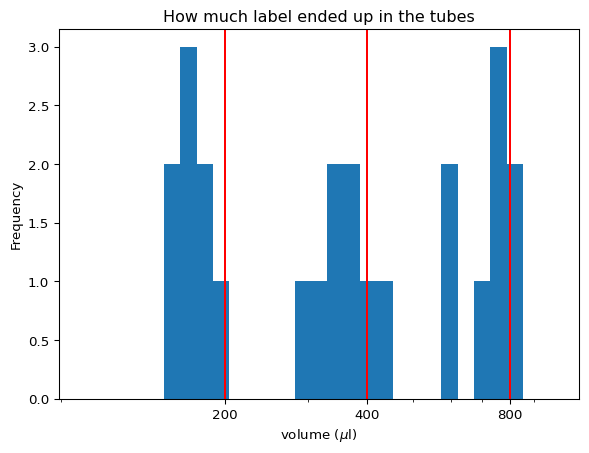

In [4]:
f, ax = plt.subplots()
bins = np.logspace(np.log10(100), np.log10(1000), 30)
ax.hist(volumes, bins=bins)
for t in (200, 400, 800):
    ax.axvline(t, color="red")
ax.semilogx()
ax.set_xticks([200, 400, 800], [200, 400, 800]);
ax.set(
    xlabel="volume ($\\mu$l)",
    ylabel="Frequency",
    title="How much label ended up in the tubes"
);

Simulate measurements for tubes in the `MEASUREMENT_IX`.

In [5]:
measurements = [
  rng.lognormal(np.log(vol), CAL_ERROR)
  for vol in volumes[MEASUREMENT_IX]
]
pd.DataFrame({
  "target volume": np.array(TARGET_VOLUMES)[MEASUREMENT_IX], 
  "actual volume": volumes[MEASUREMENT_IX],
  "measured volume": measurements
})

### Writing the model in Stan and sampling the simulated data

I wrote up the implied statistical model in a Stan file at
`src/stan/ pipette.stan`. This code loads this Stan file as a
`CmdStanModel` object, checks its formatting and prints it out.

Note that the model internally puts the data on log scale and then
standardises it: this is a bit annoying but makes it way easier to set
priors and can ultimately save you a lot of trouble.

In [6]:
model = CmdStanModel(stan_file="../src/stan/pipette.stan")
model.format(overwrite_file=True, canonicalize=True)
print(model.code())

17:48:01 - cmdstanpy - INFO - compiling stan file /Users/tedgro/repos/biosustain/bayesian_statistics_for_computational_biology/src/stan/pipette.stan to exe file /Users/tedgro/repos/biosustain/bayesian_statistics_for_computational_biology/src/stan/pipette
17:48:06 - cmdstanpy - INFO - compiled model executable: /Users/tedgro/repos/biosustain/bayesian_statistics_for_computational_biology/src/stan/pipette

functions {
  vector standardise(vector v, real m, real s) {
    return (v - m) / s;
  }
  real standardise(real v, real m, real s) {
    return (v - m) / s;
  }
  vector unstandardise(vector u, real m, real s) {
    return m + u * s;
  }
  real unstandardise(real u, real m, real s) {
    return m + u * s;
  }
}
data {
  int<lower=1> N;
  int<lower=0> N_cal;
  vector<lower=0>[N] target_volume;
  vector<lower=0>[N_cal] y;
  array[N_cal] int<lower=1, upper=N> measurement_ix;
  real<lower=0> cal_error;
  int<lower=0, upper=1> likelihood;
}
transformed data {
  vector[N_cal] y_ls = standardise(log(y), mean(log(y)), sd(log(y)));
  vector[N] target_volume_ls = standardise(log(target_volume), mean(log(y)),
                                           sd(log(y)));
  real cal_error_s = cal_error / sd(log(y));
}
parameters {
  real<lower=0> volume_noise_s;
  real bias_factor_l;
  vector[N] volume_ls;
}
model {
  volume_noise_s ~ lognormal(log(0.1), 0.5);
  bias_factor_l ~ normal(0, 0.15);
  volume

This code loads some data into a dictionary that is compatible with Stan
and carries out two MCMC runs, one in prior mode and one in posterior
mode.

In [7]:
stan_input_posterior = stanio.json.process_dictionary(
    {
      "N": N,
      "N_cal": N_CAL,
      "target_volume": TARGET_VOLUMES,
      "y": measurements,
      "measurement_ix": MEASUREMENT_IX + 1,
      "cal_error": CAL_ERROR,
      "likelihood": 1,
  }
)
stan_input_prior = stan_input_posterior | {"likelihood": 0}
mcmc_prior = model.sample(
    data=stan_input_prior,
    adapt_delta=0.999,
    max_treedepth=12,
    seed=RNG_SEED,
)
mcmc_posterior = model.sample(data=stan_input_posterior, seed=RNG_SEED)
mcmc_prior.diagnose()
mcmc_posterior.diagnose()

17:48:06 - cmdstanpy - INFO - CmdStan start processing
17:48:06 - cmdstanpy - INFO - CmdStan done processing.
17:48:06 - cmdstanpy - INFO - CmdStan start processing
17:48:06 - cmdstanpy - INFO - CmdStan done processing.
17:48:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pipette.stan', line 38, column 2 to column 71)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pipette.stan', line 38, column 2 to column 71)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pipette.stan', line 38, column 2 to column 71)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pipette.stan', line 38, column 2 to column 71)
Consider re-running with show_console=True if the above output is unclear!

'Processing csv files: /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmp9gqytwa9/pipettec_ae7eyu/pipette-20240412174806_1.csv, /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmp9gqytwa9/pipettec_ae7eyu/pipette-20240412174806_2.csv, /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmp9gqytwa9/pipettec_ae7eyu/pipette-20240412174806_3.csv, /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmp9gqytwa9/pipettec_ae7eyu/pipette-20240412174806_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

The diagnostics seem ok, though interestingly the prior was pretty
tricky to sample accurately.

### Loading the MCMC results with arviz

This code loads both MCMC runs into an arviz `InferenceData` object.

In [8]:
coords = {"obs": MEASUREMENT_IX, "tube": range(N)}
dims={
    "y": ["obs"],
    "y_rep": ["obs"],
    "target_volume": ["tube"],
    "true_volume": ["tube"],
    "volume": ["tube"],
    "tube": ["tube"]
}
idata = az.from_cmdstanpy(
    posterior=mcmc_posterior,
    prior=mcmc_prior,
    log_likelihood="llik",
    observed_data=stan_input_posterior | {
        "true_volume": volumes, "tube": range(N)
    },
    posterior_predictive={"y": "y_rep"},
    coords=coords,
    dims=dims
)
idata

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset> Size: 2MB
Dimensions: (chain: 4, draw: 1000, volume_ls_dim_0: 24, tube: 24)
Coordinates:
 * chain (chain) int64 32B 0 1 2 3
 * draw (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
 * volume_ls_dim_0 (volume_ls_dim_0) int64 192B 0 1 2 3 4 5 ... 19 20 21 22 23
 * tube (tube) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
 volume_noise_s (chain, draw) float64 32kB 0.149 0.2378 ... 0.1396 0.1959
 bias_factor_l (chain, draw) float64 32kB -0.2014 -0.07906 ... -0.07839
 volume_ls (chain, draw, volume_ls_dim_0) float64 768kB -1.275 ... ...
 bias_factor (chain, draw) float64 32kB 0.8176 0.924 ... 0.9842 0.9246
 volume_noise (chain, draw) float64 32kB 0.09116 0.1455 ... 0.1199
 volume (chain, draw, tube) float64 768kB 182.9 192.1 ... 855.2
Attributes:
 created_at: 2024-04-12T15:48:07.179626
 arviz_version: 0.17.0
 inference_library: cmdstanpy
 inference_library_version: 1.2.1 xarray.Dataset Dimensions: chain : 4 draw : 1000 volume_ls_dim_0 : 24 tube : 24 Coordinates: (4) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999 array([ 0, 1, 2, ..., 997, 998, 999]) volume_ls_dim_0 (volume_ls_dim_0) int64 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23]) tube (tube) int64 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23]) Data variables: (6) volume_noise_s (chain, draw) float64 0.149 0.2378 ... 0.1396 0.1959 array([[0.148979, 0.237794, 0.122436, ..., 0.140801, 0.178431, 0.198993],
 [0.158124, 0.141742, 0.157009, ..., 0.167521, 0.137968, 0.115493],
 [0.168817, 0.188685, 0.138985, ..., 0.138549, 0.116906, 0.133163],
 [0.151583, 0.148293, 0.18479 , ..., 0.158791, 0.139599, 0.195866]]) bias_factor_l (chain, draw) float64 -0.2014 -0.07906 ... -0.07839 array([[-0.201351 , -0.0790569, -0.105641 , ..., -0.123153 , -0.0710773,
 -0.0700885],
 [-0.0982885, -0.0746649, -0.0754556, ..., -0.128265 , -0.163382 ,
 -0.123952 ],
 [ 0.0213591, -0.182919 , -0.17903 , ..., -0.134593 , -0.132122 ,
 -0.131316 ],
 [-0.0805919, -0.0926586, -0.117743 , ..., -0.190522 , -0.0158839,
 -0.0783902]]) volume_ls (chain, draw, volume_ls_dim_0) float64 -1.275 -1.194 ... 1.099 1.246 array([[[-1.2747 , -1.19448 , -1.22282 , ..., 0.879734, 1.03417 ,
 0.762953],
 [-1.40687 , -1.09754 , -1.14365 , ..., 0.936603, 1.15697 ,
 0.907036],
 [-0.935161, -1.16238 , -1.13239 , ..., 0.901988, 1.09336 ,
 1.1396 ],
 ...,
 [-1.38442 , -1.08361 , -1.21375 , ..., 0.945476, 1.12959 ,
 1.01907 ],
 [-1.03524 , -1.11487 , -0.966034, ..., 0.964533, 1.11521 ,
 1.0335 ],
 [-1.29565 , -1.14228 , -1.38558 , ..., 0.843054, 1.08359 ,
 1.15616 ]],

 [[-1.28813 , -1.15007 , -1.30488 , ..., 0.863103, 1.06637 ,
 1.34264 ],
 [-1.17917 , -1.1655 , -1.16521 , ..., 0.874006, 1.07137 ,
 1.25143 ],
 [-1.20124 , -1.14406 , -1.0035 , ..., 0.908254, 1.06948 ,
 1.04256 ],
...
 [-1.28454 , -1.16143 , -1.07814 , ..., 0.871924, 1.07582 ,
 1.04087 ],
 [-1.35706 , -1.15124 , -1.11947 , ..., 0.87177 , 1.04045 ,
 0.944458],
 [-1.23871 , -1.14033 , -1.48308 , ..., 0.895505, 1.1146 ,
 0.996843]],

 [[-1.21437 , -1.11281 , -1.31588 , ..., 0.869607, 1.11421 ,
 0.911445],
 [-1.23622 , -1.12363 , -1.30974 , ..., 0.940612, 1.11077 ,
 1.07039 ],
 [-1.15205 , -1.14246 , -1.21216 , ..., 0.914147, 1.09383 ,
 1.10271 ],
 ...,
 [-1.28744 , -1.10417 , -1.22327 , ..., 0.90872 , 1.1949 ,
 1.00884 ],
 [-1.19644 , -1.16323 , -1.25646 , ..., 0.913467, 1.0723 ,
 1.06841 ],
 [-0.985007, -1.08883 , -1.03812 , ..., 0.941881, 1.09928 ,
 1.24558 ]]]) bias_factor (chain, draw) float64 0.8176 0.924 ... 0.9842 0.9246 array([[0.817625, 0.923987, 0.899748, ..., 0.884128, 0.93139 , 0.932311],
 [0.906387, 0.928054, 0.927321, ..., 0.87962 , 0.849267, 0.883422],
 [1.02159 , 0.832835, 0.836081, ..., 0.874071, 0.876234, 0.876941

Next we look at the summaries of both the posterior and prior.

In [9]:
for group_name in ["prior", "posterior"]:
    group = idata.get(group_name)
    group_summary = az.summary(
        group,
        var_names=[
            "volume_noise", "bias_factor", "volume_noise_s", "bias_factor_l"
        ]
    )
    display(group_summary)

### Investigating the results

This plot compares the measurements with the observations.

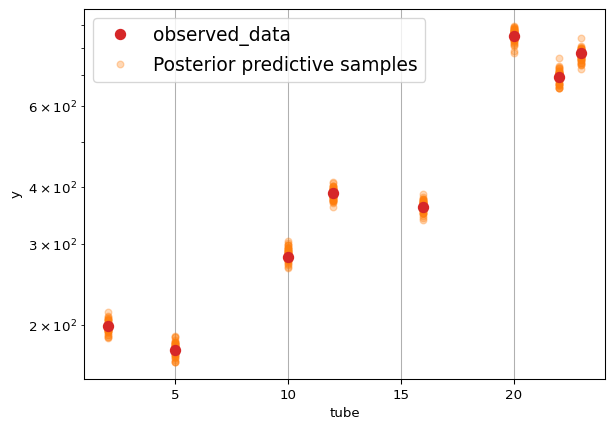

In [10]:
az.plot_lm(
    y=idata.observed_data["y"],
    x=idata.observed_data["tube"].sel(tube=MEASUREMENT_IX + 1),
    y_hat=idata.posterior_predictive["y_rep"]
)
ax = plt.gca()
ax.semilogy()

This plot compares the `volume_noise` and `bias_factor` samples with the
true values that we used to simulate the data.

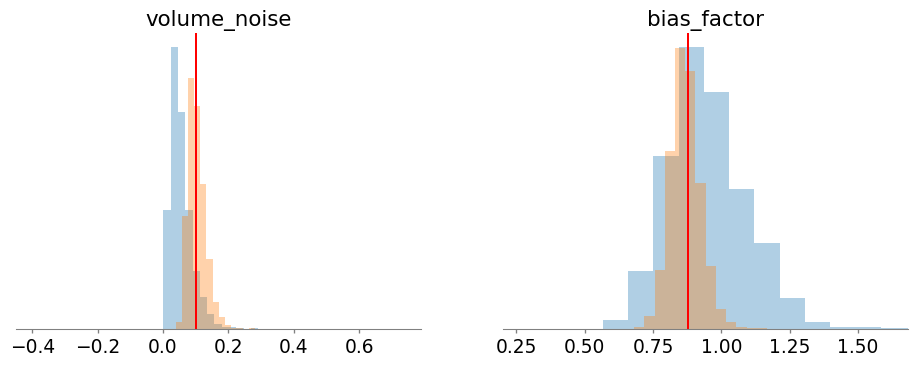

In [11]:
az.plot_posterior(
  idata.prior,
  var_names=["volume_noise", "bias_factor"],
  kind="hist",
  hdi_prob="hide",
  point_estimate=None,
  figsize=[12, 4]
)
f = plt.gcf()
axes = f.axes
az.plot_posterior(
  idata.posterior,
  var_names=["volume_noise", "bias_factor"],
  kind="hist",
  hdi_prob="hide",
  point_estimate=None,
  figsize=[12, 4],
  ax=axes,
  color="tab:orange"
)
for ax, truth in zip(f.axes, [NOISE, BIAS_FACTOR]):
    ax.axvline(truth, color="red")

This plot shows the samples for all the tubes’ volumes, including those
that weren’t measured, alongside the true volumes.

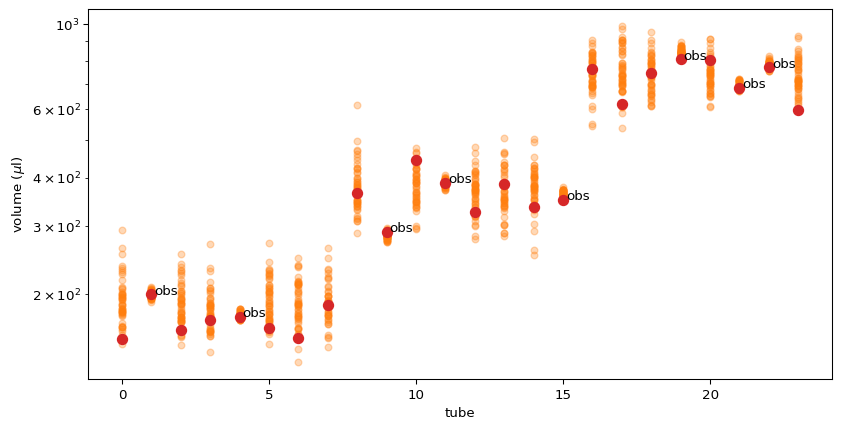

In [12]:
az.plot_lm(
    x=idata.observed_data["tube"],
    y=idata.observed_data["true_volume"],
    y_hat=idata.posterior["volume"],
    grid=False,
    y_kwargs={"label": "true volume"},
    figsize=[10, 5],
    legend=False,
)
ax = plt.gca()
for i in MEASUREMENT_IX:
    ax.text(i+0.1, volumes[i], "obs", zorder=1000)
ax.set(xlabel="tube", ylabel="volume ($\\mu$l)");
ax.semilogy()

So, what is the probability that Teddy put less than 350 $\mu$l of label
into tube 10, even though the target amount was 400$\mu$l?

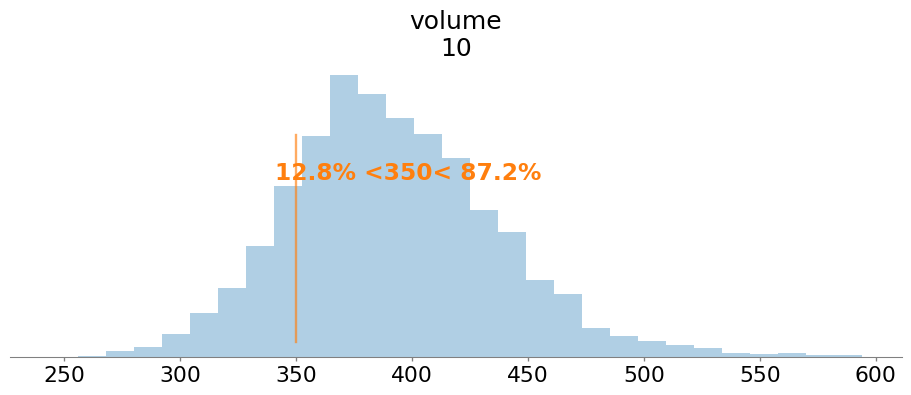

In [13]:
az.plot_posterior(
  idata.prior,
  var_names=["volume"],
  coords={"tube": [10]},
  kind="hist",
  hdi_prob="hide",
  point_estimate=None,
  ref_val=350,
  figsize=[12, 4],
  bins=np.linspace(250, 600, 30),
)

Phew, only about 13%, that’s probably fine right?

Gelman, Andrew, Jennifer Hill, and Aki Vehtari. 2020. *Regression and
Other Stories*. Cambridge University Press.

Susan Holmes, and Wolfgang Huber. 2019. *Modern Statistics for Modern
Biology*. Cambridge University Press. <https://www.huber.embl.de/msmb/>.